# Face Expression Recognition

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [120]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from numpy import expand_dims
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import model_from_json
from keras.utils import to_categorical
from keras import models, layers, Sequential
from keras.models import Model
from keras.layers import BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, Dense, AveragePooling2D
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, Callback, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Reading Data

In [3]:
dataset = pd.read_csv("/content/drive/My Drive/FER/fer2013.csv")
dataset.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [150]:
print("Shape of dataset", dataset.shape)
print("There are", dataset.shape[0],"rows and", dataset.shape[1],"columns in dataset namely", list(dataset.columns))

Shape of dataset (35887, 3)
There are 35887 rows and 3 columns in dataset namely ['emotion', 'pixels', 'Usage']


In [151]:
dataset.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

- The dataset has three columns emotion, pixels and Usage
- The pixels column contains pixel data for images
- The emotion column contains class labels
- The usage column is to select train and test data

Label = Training            :   no. of samples = 28709  (79.99832808537911% of the entire data)
Label = PrivateTest         :   no. of samples = 3589  (10.000835957310446% of the entire data)
Label = PublicTest          :   no. of samples = 3589  (10.000835957310446% of the entire data)
------------------------------------------------------------------------------------------


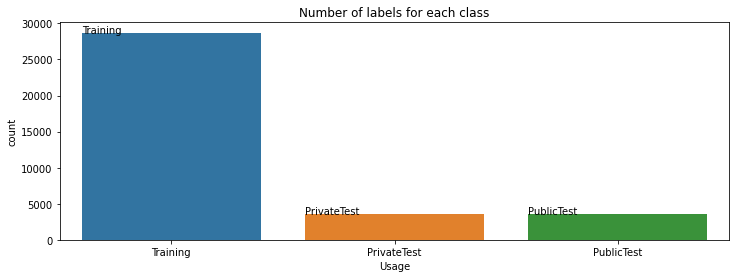

In [152]:
def classes_distribution(data):
    # Get the count for each label
    if type(data)==np.ndarray:
        data = pd.DataFrame(data)
        new_labels = data[0]
        label_counts = data[0].value_counts()
        order = np.arange(0,10)
    else:
        new_labels = data
        label_counts = data.value_counts()
        order = label_counts.index

    # Get total number of samples
    total_samples = len(data)
    
    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("Label = {:<20s}:   no. of samples = {}  ({}% of the entire data)".format(str(label), count, percent))
        
    print('-'*90)
        
    f, ax = plt.subplots(1,1, figsize=(12,4))
    img = sns.countplot(new_labels, order = order)
    img.set_title("Number of labels for each class")

    for i, label in zip(img.patches, order):
        img.annotate(label, (i.get_x(), i.get_height()+0.1))
    plt.show
    
classes_distribution(dataset['Usage'])

- The train data contains 28709 samples
- The Public test data and private test data contains 3589 samples

In [153]:
# Distribution of class labels
# 0: "Angry"
# 1: "Disgust"
# 2: "Fear"
# 3: "Happy"
# 4: "Sad"
# 5: "Surprise"
# 6: "Neutral"

dataset.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Label = 3                   :   no. of samples = 8989  (25.048067545350683% of the entire data)
Label = 6                   :   no. of samples = 6198  (17.270878033828403% of the entire data)
Label = 4                   :   no. of samples = 6077  (16.93370858528158% of the entire data)
Label = 2                   :   no. of samples = 5121  (14.269791289324827% of the entire data)
Label = 0                   :   no. of samples = 4953  (13.801655195474686% of the entire data)
Label = 5                   :   no. of samples = 4002  (11.151670521358708% of the entire data)
Label = 1                   :   no. of samples = 547  (1.524228829381113% of the entire data)
------------------------------------------------------------------------------------------


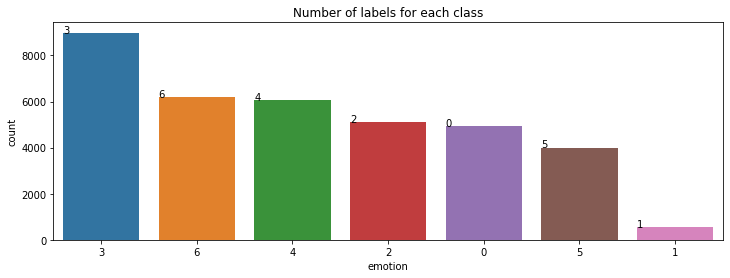

In [154]:
classes_distribution(dataset['emotion'])

- The dataset is imbalanced the label no. 1 i.e. disgust has the lowest count
- The label no. 3 i.e. happy has the highest count

## Visualizing images from dataset

In [170]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
# reshaping image into (48,48) for visualizing
def get_images(data, no_images):
    img_lst = []
    labels = []
    for index,row in enumerate(data.pixels[:no_images]):
        labels.append(data.emotion[index])
        pixels=np.asarray(row.split(' '),dtype=np.float32)
        img=pixels.reshape((48,48))
        img_lst.append(img)
    
    return img_lst, labels

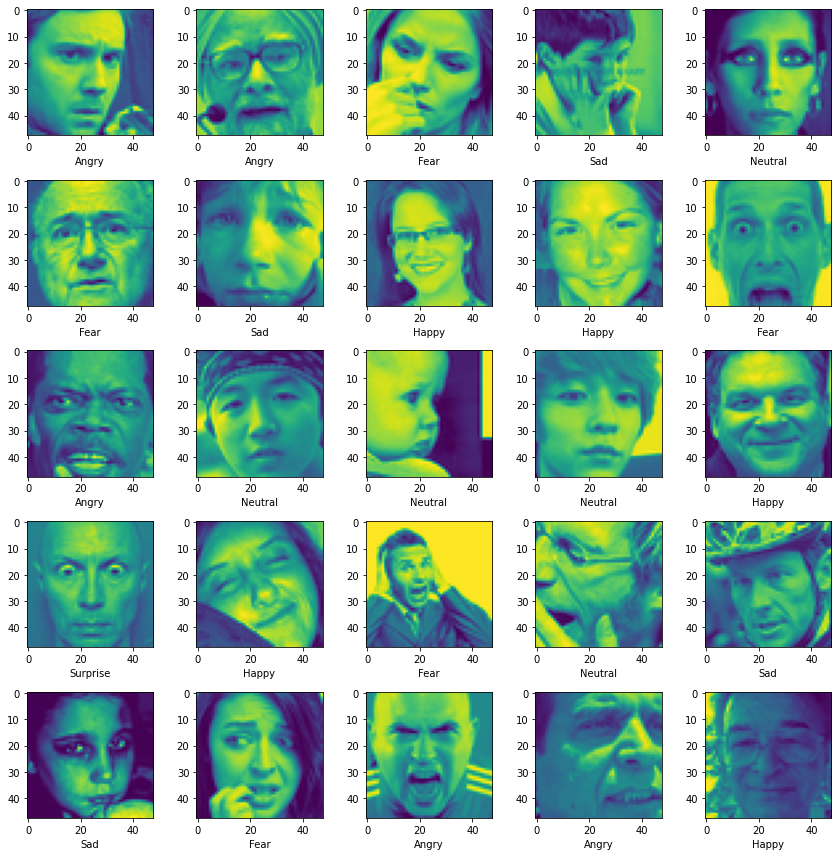

In [171]:
def plot_images(data,l,w,num_images):
    W_grid = w
    L_grid = l

    fig, axes = plt.subplots(L_grid, W_grid, figsize = (12,12))

    image_lst, labels = get_images(data,num_images)

    labels = pd.Series(labels).map(emotion_dict)
    for i,ax in enumerate(axes.flat):
        ax.imshow(image_lst[i])
        ax.set_xlabel(labels[i])
        #ax.axis('off')
        plt.tight_layout()
        
plot_images(dataset,5,5,25)

## Splitting dataset into train and test data

In [172]:
training_data = dataset[dataset['Usage']=='Training']
training_data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [177]:
public_test_data = dataset[dataset['Usage']=='PublicTest']
public_test_data.reset_index(drop = True, inplace=True)
public_test_data.head(3)

,emotion,pixels,Usage
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
1,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
2,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest


In [178]:
private_test_data = dataset[dataset['Usage']=='PrivateTest']
private_test_data.reset_index(drop = True, inplace=True)
private_test_data.head(3)

,emotion,pixels,Usage
0,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
1,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
2,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest


Label = 3                   :   no. of samples = 7202  (25.13611615245009% of the entire data)
Label = 6                   :   no. of samples = 4954  (17.290241518916655% of the entire data)
Label = 4                   :   no. of samples = 4825  (16.840011168504816% of the entire data)
Label = 2                   :   no. of samples = 4090  (14.274745218483876% of the entire data)
Label = 0                   :   no. of samples = 3982  (13.897808180929777% of the entire data)
Label = 5                   :   no. of samples = 3164  (11.042859137233004% of the entire data)
Label = 1                   :   no. of samples = 435  (1.5182186234817814% of the entire data)
------------------------------------------------------------------------------------------


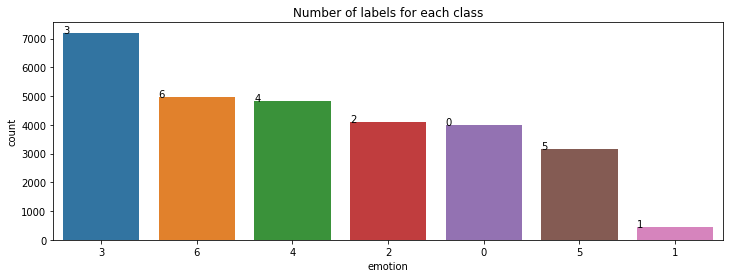

In [160]:
# Distribution of classes across train and test data
classes_distribution(training_data['emotion'])

Label = 3                   :   no. of samples = 895  (24.93730844246308% of the entire data)
Label = 4                   :   no. of samples = 653  (18.19448314293675% of the entire data)
Label = 6                   :   no. of samples = 607  (16.912789077737532% of the entire data)
Label = 2                   :   no. of samples = 496  (13.820005572582891% of the entire data)
Label = 0                   :   no. of samples = 467  (13.011981053218166% of the entire data)
Label = 5                   :   no. of samples = 415  (11.56310950125383% of the entire data)
Label = 1                   :   no. of samples = 56  (1.560323209807746% of the entire data)
------------------------------------------------------------------------------------------


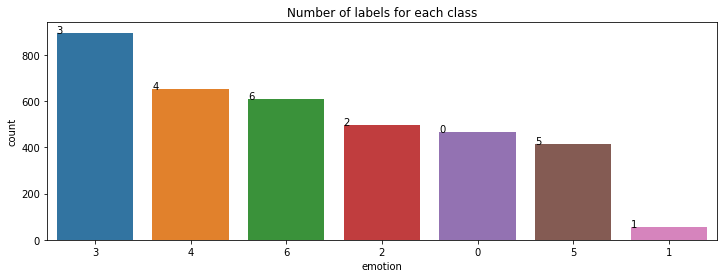

In [161]:
classes_distribution(public_test_data['emotion'])

Label = 3                   :   no. of samples = 879  (24.49150181108944% of the entire data)
Label = 6                   :   no. of samples = 626  (17.44218445249373% of the entire data)
Label = 4                   :   no. of samples = 594  (16.550571189746446% of the entire data)
Label = 2                   :   no. of samples = 528  (14.711618835330176% of the entire data)
Label = 0                   :   no. of samples = 491  (13.68069100027863% of the entire data)
Label = 5                   :   no. of samples = 416  (11.590972415714685% of the entire data)
Label = 1                   :   no. of samples = 55  (1.5324602953468933% of the entire data)
------------------------------------------------------------------------------------------


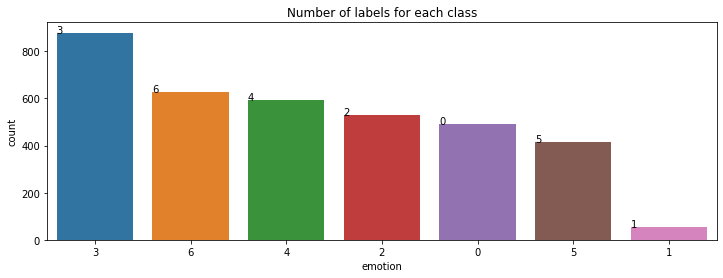

In [162]:
classes_distribution(private_test_data['emotion'])

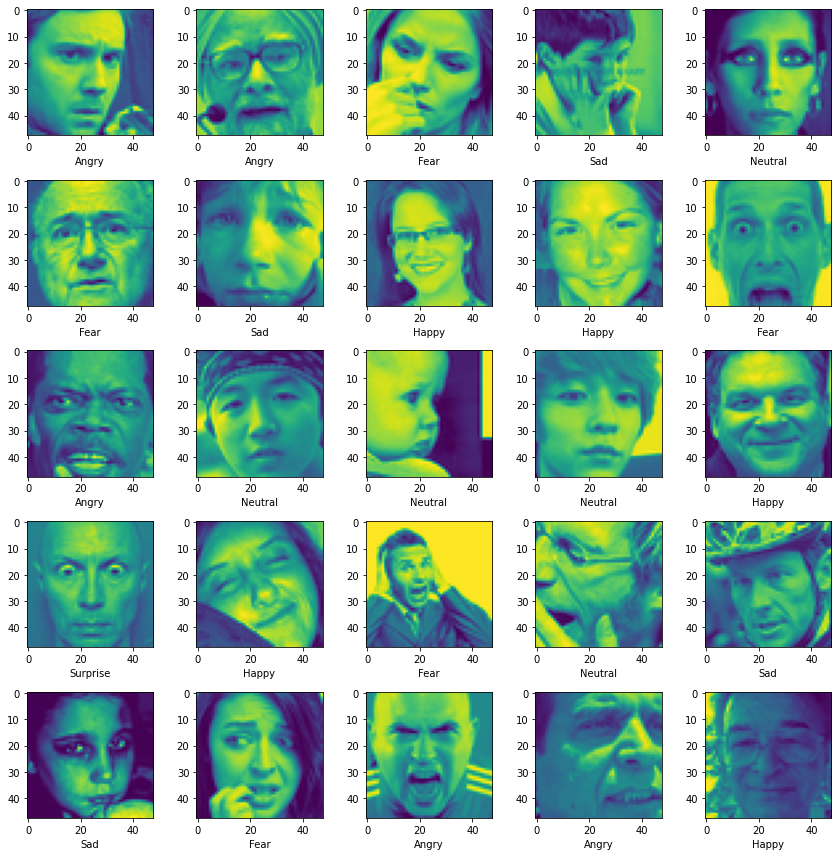

In [175]:
## Visualizing images from train and test data
plot_images(training_data, 5, 5, 25)

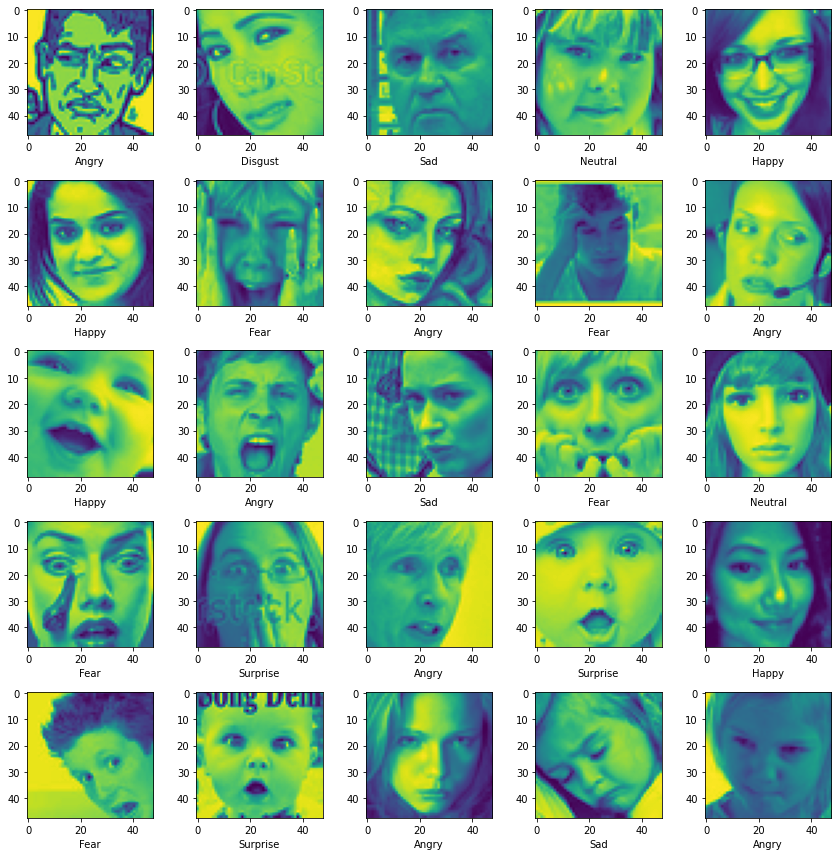

In [179]:
plot_images(public_test_data, 5, 5, 25)

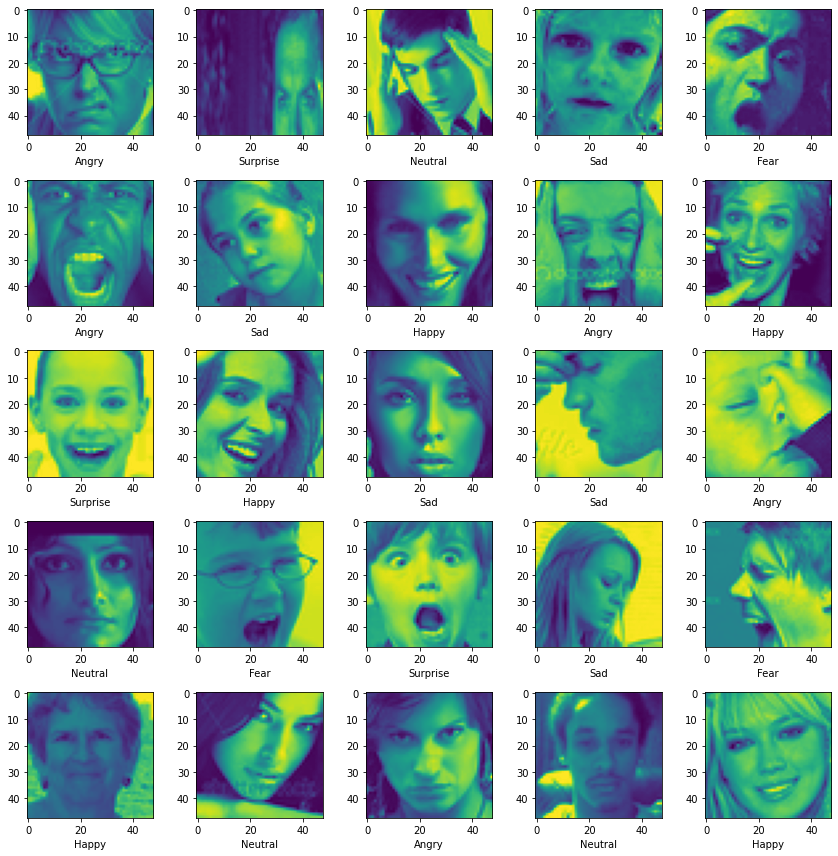

In [180]:
plot_images(private_test_data, 5, 5, 25)

## Data Cleaning

In [ ]:
# Here we will save the images from training data to drive and manually check the images for any bad training data or
# misclassified labels
emotion_list = training_data.emotion.map(emotion_dict)
path ='drive/My Drive/FER/images/'
def save_fer_images(dataset, n = len(training_data.values)):
    for index,row in enumerate(dataset.pixels[:n]):
        pixels=np.asarray(row.split(' '),dtype=np.float32)
        img=pixels.reshape((48,48))
        pathname=os.path.join(path, str(index)+' '+str(emotion_list[index])+'.jpg')
        cv2.imwrite(pathname,img)

In [ ]:
save_fer_images(training_data)

In [86]:
# we found 57 images in the training data that are completely useless
# lots of images also have misclassified labels
# we saved the index of these images in a text file
bad_data_index = [int(word.strip('\n')) for word in open("drive/My Drive/FER/bad_data.txt", 'r').readlines()]
len(bad_data_index)

57

In [94]:
# now lets visualize this bad training images
bad_data_plot=bad_data_index[25:50]
bad_data_lst = []
bad_data_labels = []
for index,row in enumerate(training_data.pixels[bad_data_plot]):
    bad_data_labels.append(training_data.emotion[bad_data_plot[index]])
    pixels=np.asarray(row.split(' '),dtype=np.float32)
    bad_imgs=pixels.reshape((48,48))
    bad_data_lst.append(bad_imgs)

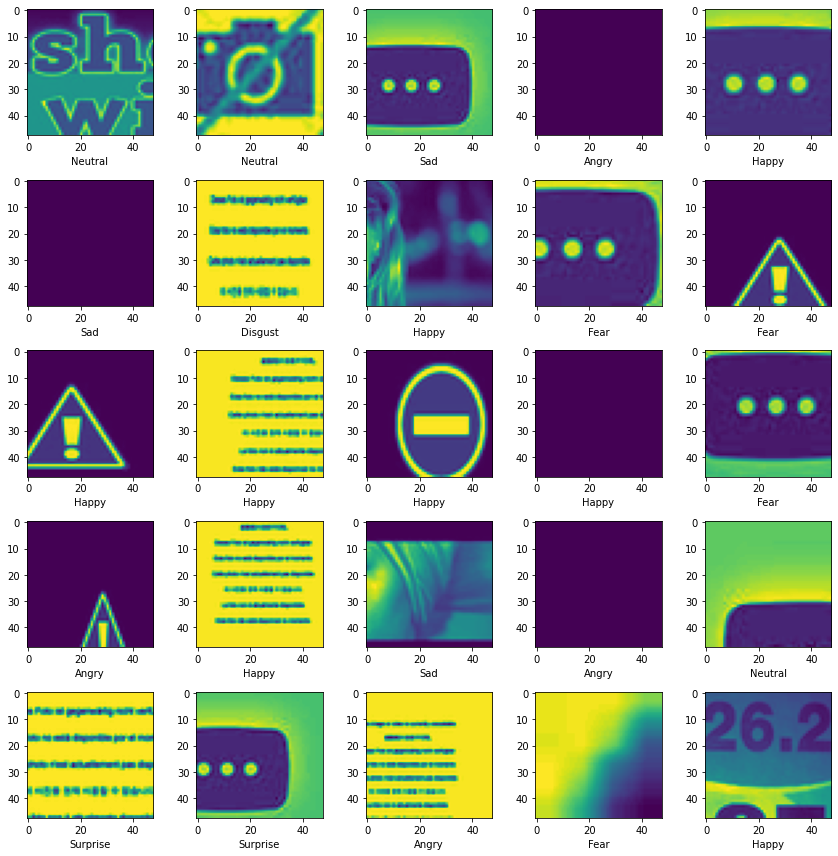

In [96]:
fig, axes = plt.subplots(5, 5, figsize = (12,12))

bad_data_labels = pd.Series(bad_data_labels).map(emotion_dict)
for i,ax in enumerate(axes.flat):
    ax.imshow(bad_data_lst[i])
    ax.set_xlabel(bad_data_labels[i])
    #ax.axis('off')
    plt.tight_layout()
  

- As we can see these training images are completely useless
- we will remove these images from the training data

In [97]:
training_data.shape

(28709, 3)

In [149]:
# we will drop the rows of these images from the training dataset as they are completely useless
training_data = training_data.drop(training_data.index[bad_data_index])
training_data.shape

(28652, 3)

## CNN Model

In [101]:
num_classes = len(dataset.emotion.value_counts())

In [102]:
#reshaping train and test data into (height, width, channel) for model
def reshaped_images(data):
  images = []
  for i in data.pixels.values.tolist():
      pixels = np.array(i.split(" "), 'float32')
      imgs=pixels.reshape((48,48,1))
      images.append(imgs)
     
  return np.array(images)

In [106]:
x_train = training_data.drop(['emotion', 'Usage'], axis=1)
x_train = reshaped_images(x_train)
y_train = training_data['emotion']
print(x_train.shape)
print(y_train.shape)

x_public_test = public_test_data.drop(['emotion', 'Usage'], axis=1)
x_public_test = reshaped_images(x_public_test)
y_public_test = public_test_data['emotion']
print(x_public_test.shape)
print(y_public_test.shape)

x_private_test = private_test_data.drop(['emotion', 'Usage'], axis=1)
x_private_test = reshaped_images(x_private_test)
y_private_test = private_test_data['emotion']
print(x_private_test.shape)
print(y_private_test.shape)

(28652, 48, 48, 1)
(28652,)
(3589, 48, 48, 1)
(3589,)
(3589, 48, 48, 1)
(3589,)


In [ ]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y=y_train)
#class_weights_dict = dict(enumerate(class_weights))

In [107]:
# converting test labels to categorical data
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes)
y_public_test = to_categorical(y_public_test, num_classes)
y_private_test = to_categorical(y_private_test, num_classes)

In [108]:
#image data generator for image augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=12,
    zoom_range=0.2,
    fill_mode='nearest'
)


In [109]:
#fitting image data generator on train data
datagen.fit(x_train)

batchx, batchy = datagen.flow(x_train[:1000], y_train[:1000], batch_size=1000).next()
print('Batch shape = %s, min = %.3f max=%.3f'%(batchx.shape, batchx.min(), batchx.max()))

Batch shape = (1000, 48, 48, 1), min = 0.000 max=255.000


In [110]:
img_height, img_width, channel = x_train.shape[1], x_train.shape[2], x_train.shape[3]

In [124]:
lr_reduce= ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=8, verbose=1)

filepath = 'drive/My Drive/FER_new/model_output/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', patience=16, verbose=1, mode='max', restore_best_weights=True)

In [136]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, channel), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(num_classes, activation='softmax'))

In [137]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['accuracy'])

In [138]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 23, 23, 128)      

In [ ]:
train_model = model.fit_generator(datagen.flow(x_train, y_train, batch_size=58),
                                    epochs=200,verbose = 1,
                                    validation_data=(x_public_test, y_public_test), 
                                    callbacks=[checkpoint, lr_reduce, early_stop])

Epoch 1/200
495/495 [==============================] - ETA: 0s - loss: 1.9660 - accuracy: 0.2143
Epoch 00001: val_accuracy improved from -inf to 0.24937, saving model to drive/My Drive/FER_new/model_output/model-001-0.214323-0.249373.h5
495/495 [==============================] - 17s 35ms/step - loss: 1.9660 - accuracy: 0.2143 - val_loss: 1.8217 - val_accuracy: 0.2494 - lr: 0.0010
Epoch 2/200
495/495 [==============================] - ETA: 0s - loss: 1.8195 - accuracy: 0.2500
Epoch 00002: val_accuracy improved from 0.24937 to 0.27445, saving model to drive/My Drive/FER_new/model_output/model-002-0.250026-0.274450.h5
495/495 [==============================] - 17s 34ms/step - loss: 1.8195 - accuracy: 0.2500 - val_loss: 1.7776 - val_accuracy: 0.2744 - lr: 0.0010
Epoch 3/200
495/495 [==============================] - ETA: 0s - loss: 1.7562 - accuracy: 0.2872
Epoch 00003: val_accuracy did not improve from 0.27445
495/495 [==============================] - 16s 33ms/step - loss: 1.7562 - accur

In [ ]:
score_public_test = model.evaluate(x_public_test, y_public_test)
print('Test loss on public test data:', score_public_test[0])
print('Test accuracy on public test data:', score_public_test[1])

113/113 [==============================] - 1s 7ms/step - loss: 0.9719 - accuracy: 0.6640
Test loss on public test data: 0.9718844890594482
Test accuracy on public test data: 0.6639732718467712


In [ ]:
score_private_test = model.evaluate(x_private_test, y_private_test)
print('Test loss on private test data:', score_private_test[0])
print('Test accuracy on private test data:', score_private_test[1])

113/113 [==============================] - 1s 7ms/step - loss: 0.9186 - accuracy: 0.6782
Test loss on private test data: 0.918609619140625
Test accuracy on private test data: 0.6781833171844482


In [ ]:
## Save Model to Drive

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("drive/My Drive/FER/fer_model.json", "w") as json_file:
  json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("drive/My Drive/FER/fer_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
## Load Model from Drive

In [139]:
json_file = open('drive/My Drive/FER/fer_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load best weights into new model
model.load_weights("drive/My Drive/FER/fer_model_weights.h5")
print("loaded model from disk")

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

loaded model from disk


In [ ]:
## Testing our model on images from private test data

In [ ]:
def save_test_images(dataset, n = len(dataset.values)):
    for index,row in enumerate(dataset.pixels[:n]):
        pixels=np.asarray(row.split(' '),dtype=np.float32)
        img=pixels.reshape((48,48))
        pathname=os.path.join('fer_image_'+str(index)+'.jpg')
        cv2.imwrite(pathname,img)
        print('image saved as {}'.format(pathname))

In [130]:
save_test_images(private_test_data, 10)

image saved as fer_image_0.jpg
image saved as fer_image_1.jpg
image saved as fer_image_2.jpg
image saved as fer_image_3.jpg
image saved as fer_image_4.jpg
image saved as fer_image_5.jpg
image saved as fer_image_6.jpg
image saved as fer_image_7.jpg
image saved as fer_image_8.jpg
image saved as fer_image_9.jpg


In [142]:
colrs = ['red', 'brown', 'black', 'yellow', 'gray', 'magenta', 'cyan']

In [143]:
emotion_list = []
image_list =[]
for i in range(10):
  img = image.load_img("fer_image_"+str(i)+".jpg", grayscale=True, target_size=(48, 48))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  e_pred = model.predict(x)

  x = np.array(x, 'float32')
  x = x.reshape([48, 48]);
  image_list.append(x)

  emotion_list.append(e_pred[0])


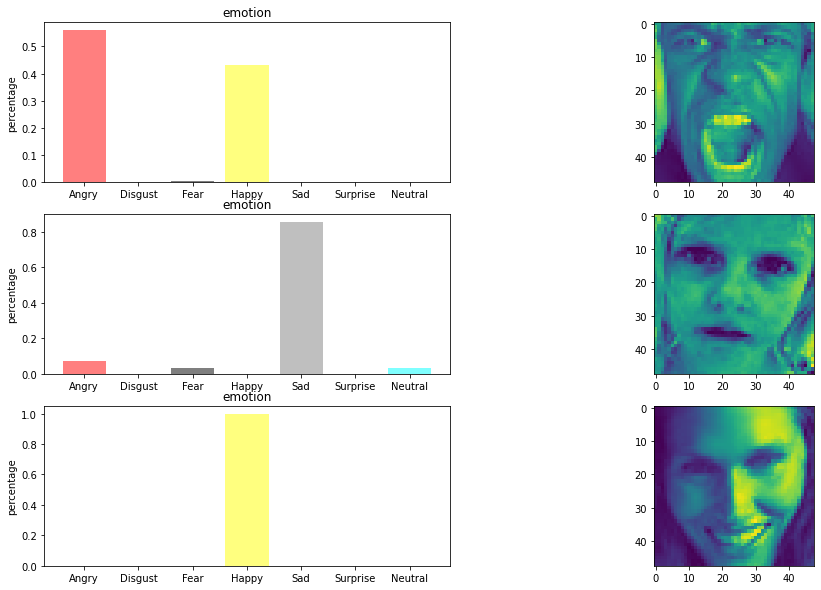

In [148]:
fig = plt.figure(figsize=(16,10))
plt.subplot(3,2,1)
plt.bar(list(emotion_dict.keys()), emotion_list[5], align='center', alpha=0.5, color=(colrs))
plt.xticks(list(emotion_dict.keys()), list(emotion_dict.values()))
plt.ylabel('percentage')
plt.title('emotion')

plt.subplot(3,2,2)
plt.imshow(image_list[5])

plt.subplot(3,2,3)
plt.bar(list(emotion_dict.keys()), emotion_list[3], align='center', alpha=0.5, color=(colrs))
plt.xticks(list(emotion_dict.keys()), list(emotion_dict.values()))
plt.ylabel('percentage')
plt.title('emotion')

plt.subplot(3,2,4)
plt.imshow(image_list[3])

plt.subplot(3,2,5)
plt.bar(list(emotion_dict.keys()), emotion_list[7], align='center', alpha=0.5, color=(colrs))
plt.xticks(list(emotion_dict.keys()), list(emotion_dict.values()))
plt.ylabel('percentage')
plt.title('emotion')

plt.subplot(3,2,6)
plt.imshow(image_list[7])

- Here we can see the model has a 68 percent accuracy on test data
- The accuracy can further be improved by further cleaning the data
- More data can be collected or class weights can be used to further improve the model predictions by balancing the data
- The model is classifying the test data images quite correctly 